# Ejercicio de filtros de segmentación
**Autor:** Guerrero Deschamps, Raúl  
**Fecha:** 10/08/2021  
**Asignatura:** Percepción Computacional  
**GitHub:** https://github.com/raul-guerrero/EliminacionAnomalias/tree/master/notebooks  

### Descripción del problema
Crear un método para recortar el fondo en una "selfie" y solamente tomar el segmento donde se encuentra la persona tomándose la foto, para una red social de búsqueda de empleo, en la cual aplicantes puedan subir una "selfie" y el portal web automáticamente elimine el fondo de la imagen y pueda usar solamente el segmento de la persona para ponerla como parte de su foto de perfil, facilitando a los aplicantes el hecho de tener que recortar fotos sin fondo por sus propios medios.

### Solución propuesta
Al obtener una foto de tipo "selfie", aplicaremos dos filtros de segmentación sobre 2 fotos distintas, luego analizaremos cual hizo un mejor trabajo segmentando al comparar los resultados con imágenes de referencia "ground truth", la que logre mejores resultados, es la que usaremos para nuestra solución. 

Esta solución incluirá 3 pasos:
1. Mostrar dos fotos "selfies" originales con sus respectivas referencias de "ground truth".
2. Aplicar un filtro de tipo Watershed y otro de GrabCut a las dos selfies para comparar los resultados con sus respectivos "ground truth" para identificar a una persona sobre su paisaje de fondo.
3. Demostramos que el algoritmo de GrabCut funciona mejor que Watershed, por lo que la solución final identifica a la persona en una "selfie" y muestra la imagen que solo contiene la persona identificada con fondo blanco para su uso en la red social de búsqueda de empleo.

### Ejecución comentada paso a paso

Se incluyen las librerías para leer y escribir imágenes, al igual que la librería OpenCV para aplicar los filtros de Watershed y Grabcut a las selfies.

In [49]:
import cv2 as cv
import numpy as np
import imutils
from PIL import Image as im
from IPython.display import Image
from IPython.display import display

Se muestran las selfies que usaremos para probar nuestra solución con sus respectivos "ground truth"

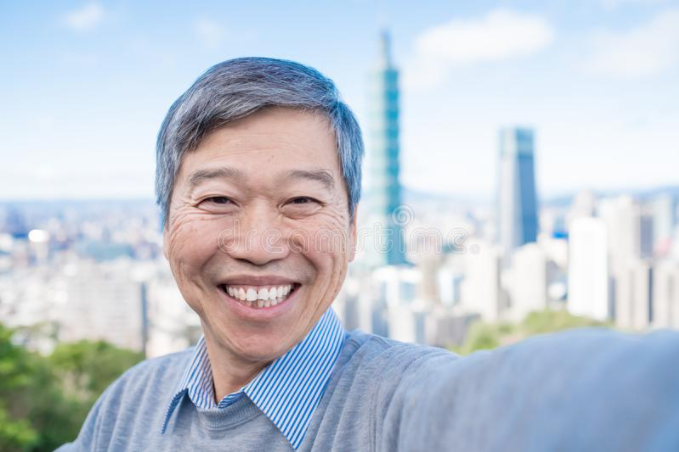

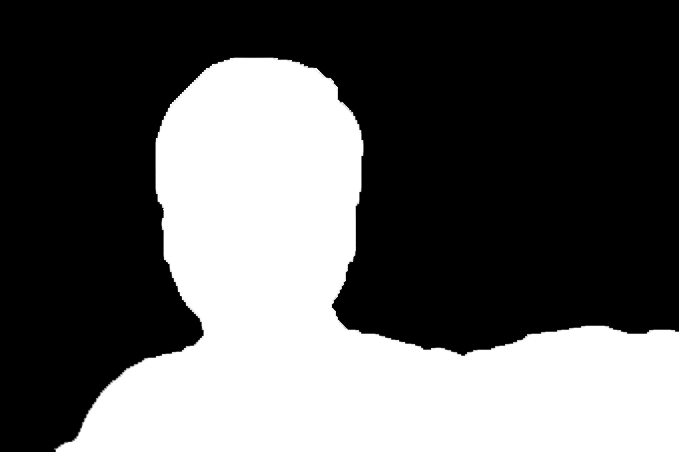

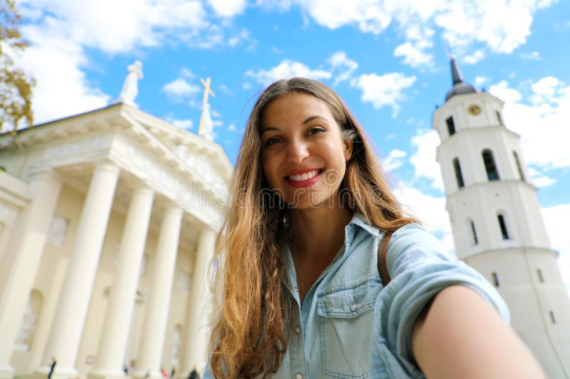

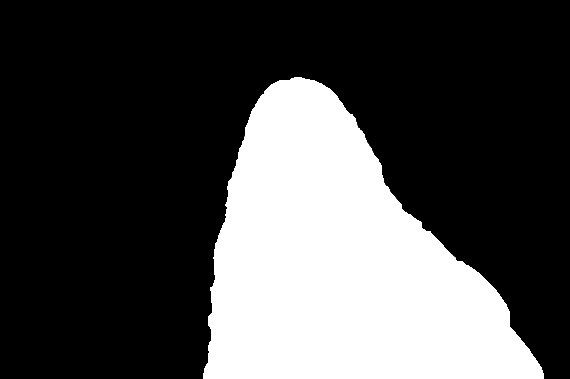

In [50]:
display(Image("segmentacion/2.png"))
display(Image("segmentacion/2gt.png"))
display(Image("segmentacion/3.png"))
display(Image("segmentacion/3gt.png"))

Aplicamos el filtro Watershed

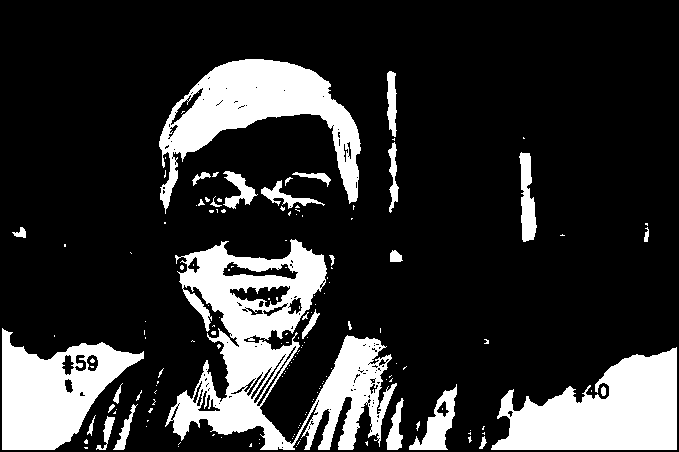

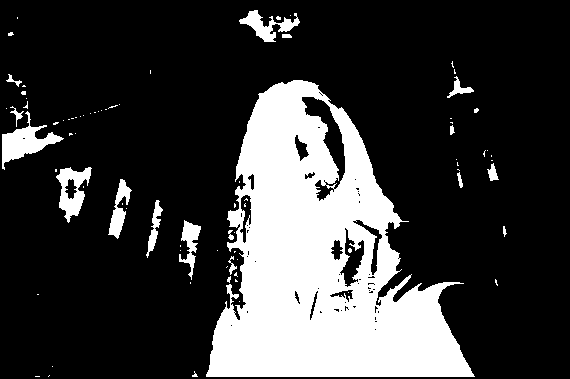

In [51]:
def aplicarWatershedMascara(foto):
    image = cv.imread(foto)
    img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    ret, thresh_img = cv.threshold(img_gray, 170, 255, cv.THRESH_BINARY_INV)
    ret, markers = cv.connectedComponents(thresh_img)
    markers = markers + 1
    markers = cv.watershed(image, markers)
    cnts = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    for (i, c) in enumerate(cnts):
        ((x, y), _) = cv.minEnclosingCircle(c)
        cv.putText(thresh_img, "#{}".format(i + 1), (int(x) - 10, int(y)),
            cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv.drawContours(thresh_img, [c], -1, (0, 255, 0), 2)
    
    return thresh_img
display(im.fromarray(aplicarWatershedMascara("segmentacion/2.png")))
display(im.fromarray(aplicarWatershedMascara("segmentacion/3.png")))

Aplicamos el filtro GrabCut

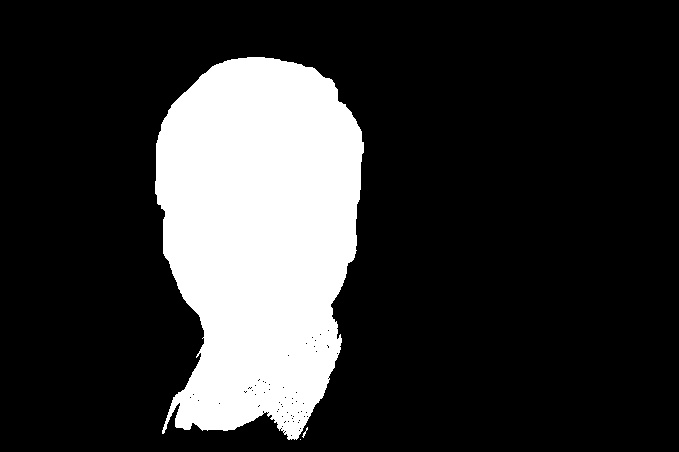

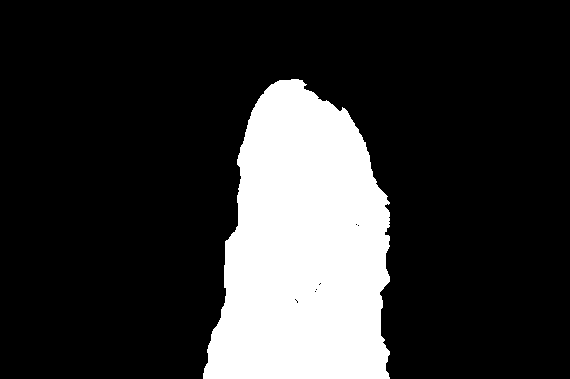

In [52]:
def aplicarGrabCutMascara(foto):
    image = cv.imread(foto)
    mask = np.zeros(image.shape[:2], dtype="uint8")
    rect = (140, 40, 250, 400)
    fgModel = np.zeros((1, 65), dtype="float")
    bgModel = np.zeros((1, 65), dtype="float")
    (mask, bgModel, fgModel) = cv.grabCut(image, mask, rect, bgModel, fgModel, iterCount=5, mode=cv.GC_INIT_WITH_RECT)
    outputMask = np.where((mask == cv.GC_BGD) | (mask == cv.GC_PR_BGD), 0, 1)
    outputMask = (outputMask * 255).astype("uint8")
    return outputMask
display(im.fromarray(aplicarGrabCutMascara("segmentacion/2.png")))
display(im.fromarray(aplicarGrabCutMascara("segmentacion/3.png")))

Al comparar las imágenes anteriores con los ground truths, mostramos que el GrabCut es mejor opción, así que, usando GrabCut extraemos a la persona de la selfie y la mostramos en pantalla con el fondo eliminado.

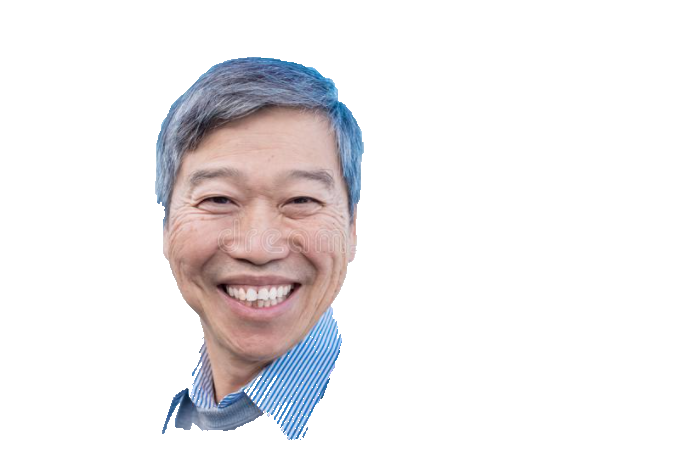

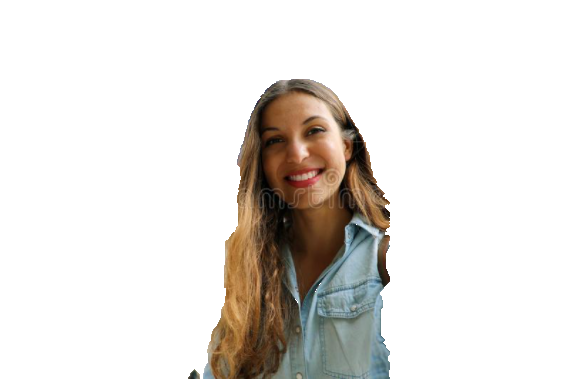

In [53]:
def aplicarGrabCut(foto):
    image = cv.imread(foto)
    mask = np.zeros(image.shape[:2], dtype="uint8")
    rect = (140, 40, 250, 400)
    fgModel = np.zeros((1, 65), dtype="float")
    bgModel = np.zeros((1, 65), dtype="float")
    (mask, bgModel, fgModel) = cv.grabCut(image, mask, rect, bgModel, fgModel, iterCount=5, mode=cv.GC_INIT_WITH_RECT)
    outputMask = np.where((mask == cv.GC_BGD) | (mask == cv.GC_PR_BGD), 0, 1)
    outputMask = (outputMask * 255).astype("uint8")
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    output = cv.merge(cv.split(image) + [outputMask])
    return output
display(im.fromarray(aplicarGrabCut("segmentacion/2.png")))
display(im.fromarray(aplicarGrabCut("segmentacion/3.png")))